## PERC Rule for Pulmonary Embolism

### Seven Criteria of PERC Rule



1. Age < 50 years
2. Heart rate < 100 bpm
3. Oxygen saturation ≥ 95% 
4. No hemoptysis
5. No estrogen use
6. No prior venous thromboembolism (VTE)
7. No unilateral leg swelling

### Quick Overview

In [142]:
from datasets import load_dataset
import pandas as pd
import ast
import json
import matplotlib.pyplot as plt
import os
import requests
import sys
import re
import numpy as np
import asyncio
import aiohttp
from typing import List
import seaborn as sns
import builtins








# Load dataset
dataset = load_dataset("ncbi/MedCalc-Bench-v1.0")
df = dataset["train"].to_pandas()  # or "test"
df_test = dataset["test"].to_pandas()  # or "test"
# Filter for calculator name "PERC"

perc_df = df[df["Calculator Name"] == "PERC Rule for Pulmonary Embolism"]
perc_df.head(5)

perc_df_test = df_test[df_test["Calculator Name"] == "PERC Rule for Pulmonary Embolism"]
perc_df_test.head(5)
perc_df["Relevant Entities"].iloc[0]


"{'age': [73, 'years'], 'Heart Rate or Pulse': [92.0, 'beats per minute'], 'Hemoptysis': False, 'O₂ saturation percentage': [98.0, '%'], 'Unilateral Leg Swelling': False, 'Hormone use': True, 'Recent surgery or trauma': True, 'Previously documented Deep Vein Thrombosis': False, 'Previously Documented Pulmonary Embolism': False}"

Training Data
count     133.000000
mean      478.037594
std       250.493192
min        80.000000
25%       300.000000
50%       469.000000
75%       639.000000
max      1378.000000
Name: space_count, dtype: float64

Test Data
count     20.000000
mean     434.900000
std      204.539508
min       90.000000
25%      333.750000
50%      413.000000
75%      536.500000
max      795.000000
Name: space_count, dtype: float64


/var/folders/y5/cg9ckmtx691dkg8sg071p0qw0000gq/T/ipykernel_86022/3430931338.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perc_df["space_count"] = perc_df["Patient Note"].astype(str).apply(lambda x: x.count(" "))
/var/folders/y5/cg9ckmtx691dkg8sg071p0qw0000gq/T/ipykernel_86022/3430931338.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perc_df_test["space_count"] = perc_df_test["Patient Note"].astype(str).apply(lambda x: x.count(" "))


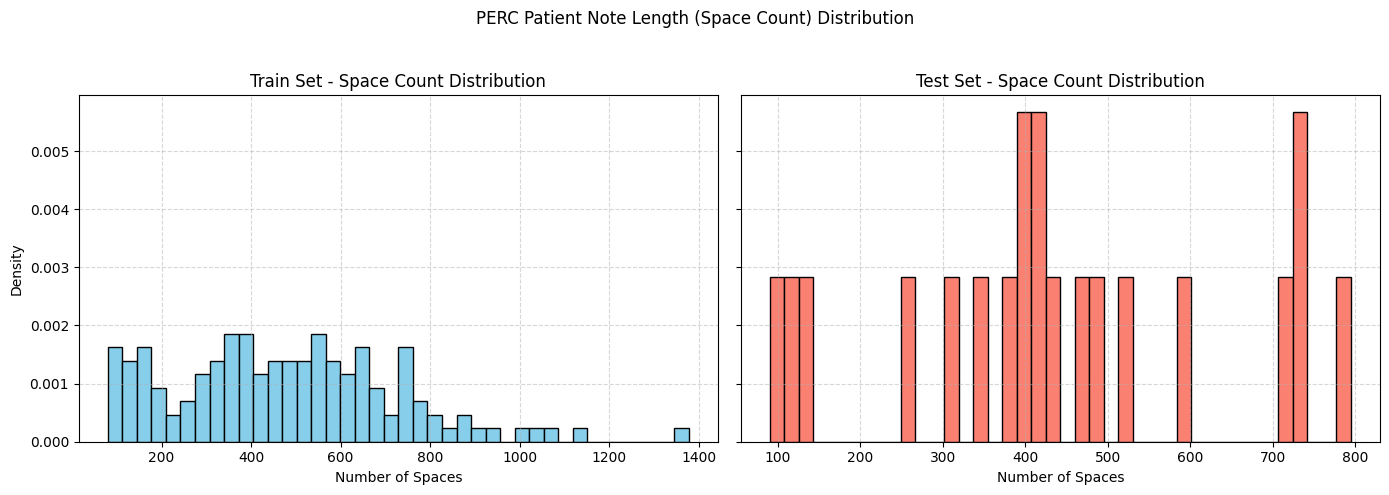

In [144]:

# Train: space count
perc_df["space_count"] = perc_df["Patient Note"].astype(str).apply(lambda x: x.count(" "))

# Test: space count
perc_df_test["space_count"] = perc_df_test["Patient Note"].astype(str).apply(lambda x: x.count(" "))

# Basic stats
print("Training Data")
print(perc_df["space_count"].describe())

print("\nTest Data")
print(perc_df_test["space_count"].describe())

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

axes[0].hist(perc_df["space_count"], bins=40, color='skyblue', edgecolor='black', density=True)
axes[0].set_title("Train Set - Space Count Distribution")
axes[0].set_xlabel("Number of Spaces")
axes[0].set_ylabel("Density")
axes[0].grid(True, linestyle='--', alpha=0.5)

axes[1].hist(perc_df_test["space_count"], bins=40, color='salmon', edgecolor='black', density=True)
axes[1].set_title("Test Set - Space Count Distribution")
axes[1].set_xlabel("Number of Spaces")
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.suptitle("PERC Patient Note Length (Space Count) Distribution")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


"{'age': [73, 'years'], 'Heart Rate or Pulse': [92.0, 'beats per minute'], 'Hemoptysis': False, 'O₂ saturation percentage': [98.0, '%'], 'Unilateral Leg Swelling': False, 'Hormone use': True, 'Recent surgery or trauma': True, 'Previously documented Deep Vein Thrombosis': False, 'Previously Documented Pulmonary Embolism': False}"

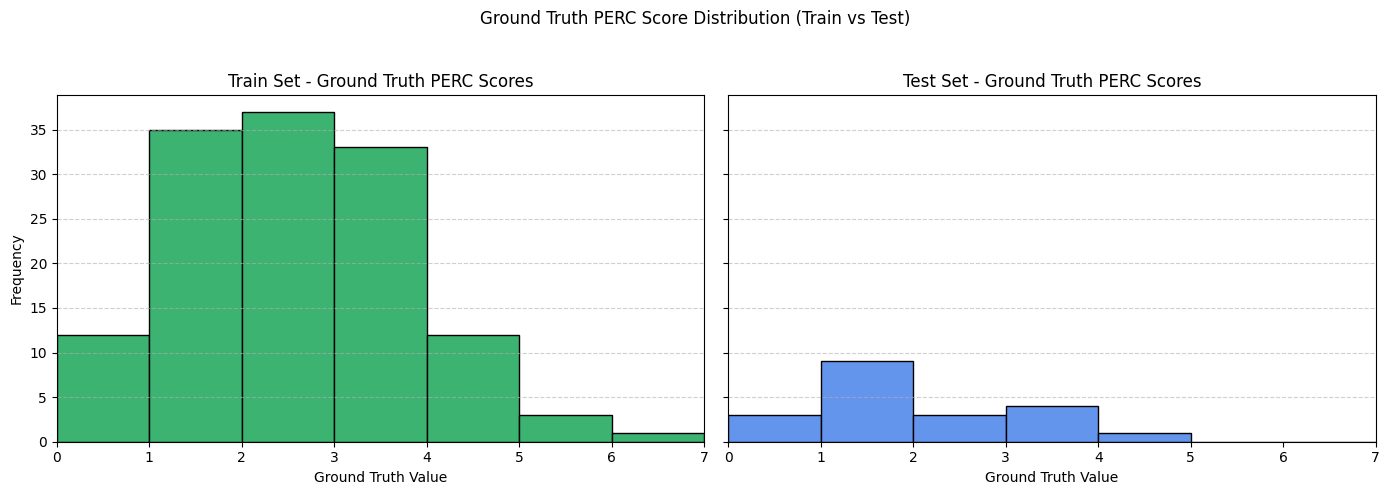

In [37]:

# Ensure Ground Truth Answer is numeric and use .loc
perc_df.loc[:, "Ground Truth Answer"] = pd.to_numeric(perc_df["Ground Truth Answer"], errors="coerce")
perc_df_test.loc[:, "Ground Truth Answer"] = pd.to_numeric(perc_df_test["Ground Truth Answer"], errors="coerce")

# Drop NaNs
cleaned_train = perc_df["Ground Truth Answer"].dropna()
cleaned_test = perc_df_test["Ground Truth Answer"].dropna()

# Plot side-by-side histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

bins = range(0, 8)  # PERC scores range from 0 to 7

axes[0].hist(cleaned_train, bins=bins, color="mediumseagreen", edgecolor="black")
axes[0].set_title("Train Set - Ground Truth PERC Scores")
axes[0].set_xlabel("Ground Truth Value")
axes[0].set_ylabel("Frequency")
axes[0].set_xlim(0, 7)
axes[0].grid(axis="y", linestyle="--", alpha=0.6)

axes[1].hist(cleaned_test, bins=bins, color="cornflowerblue", edgecolor="black")
axes[1].set_title("Test Set - Ground Truth PERC Scores")
axes[1].set_xlabel("Ground Truth Value")
axes[1].set_xlim(0, 7)
axes[1].grid(axis="y", linestyle="--", alpha=0.6)

plt.suptitle("Ground Truth PERC Score Distribution (Train vs Test)")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### Function to calculate PERC Score

In [38]:
#Testing calcualtor
def perc_score(
    age,
    heart_rate,
    oxygen_saturation,
    has_hemoptysis=False,
    on_estrogen=False,
    history_dvt_pe=False,
    unilateral_leg_swelling=False,
    recent_trauma_or_surgery=False
):
    """
    Calculate the PERC rule score.
    Returns the number of failed criteria (0 = all passed, 8 = all failed).
    """
    score = 0
    if age >= 50:
        score += 1
    if heart_rate >= 100:
        score += 1
    if oxygen_saturation < 95:
        score += 1
    if has_hemoptysis:
        score += 1
    if on_estrogen:
        score += 1
    if history_dvt_pe:
        score += 1
    if unilateral_leg_swelling:
        score += 1
    if recent_trauma_or_surgery:
        
        score += 1
    return score


### Function to safely parse the "Relevant Entities" column

In [ ]:

''''This function safely parses a string representation (val) of a dictionary or list similar to to_dict()'''
def safe_parse(val):
    if isinstance(val, dict):
        return val
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return None

# Using perc_df["Relevant Entities"].to_dict() to parse the "Relevant Entities" column produces the same result as perc_df["Parsed Entities"].
perc_df["Parsed Entities"] = perc_df["Relevant Entities"].apply(safe_parse)


entities_df = pd.json_normalize(perc_df["Parsed Entities"])


def get_value(item):
    if isinstance(item, list) and item:
        return item[0]
    return item

entities_cleaned = entities_df.map(get_value)

'''This function extracts the first element from a list or returns the item itself if it's not a list.
Mainly to account for values with units such as ["73","years]'''
def extract_number(val):
    if isinstance(val, list) and len(val) > 0:
        return val[0]
    elif isinstance(val, (int, float)):
        return val
    else:
        return None
    
def calculate_perc_score_from_entities(entities):
    """Extracts values from entity dict and returns the computed PERC score."""
    age = extract_number(get_value(entities.get("age")))
    heart_rate = extract_number(get_value(entities.get("Heart Rate or Pulse")))
    o2_sat = extract_number(get_value(entities.get("O₂ saturation percentage")))

    hemoptysis = get_value(entities.get("Hemoptysis"), False)
    hormone_use = get_value(entities.get("Hormone use"), False)
    prior_pe_dvt = get_value(entities.get("Previously documented Deep Vein Thrombosis"), False) or \
                   get_value(entities.get("Previously Documented Pulmonary Embolism"), False)
    leg_swelling = get_value(entities.get("Unilateral Leg Swelling"), False)
    recent_surgery_trauma = get_value(entities.get("Recent surgery or trauma"), False)

    return perc_score(age, heart_rate, o2_sat, hemoptysis, hormone_use, prior_pe_dvt, leg_swelling, recent_surgery_trauma)


/var/folders/y5/cg9ckmtx691dkg8sg071p0qw0000gq/T/ipykernel_86022/194774003.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perc_df["Parsed Entities"] = perc_df["Relevant Entities"].apply(safe_parse)


### Testing the Calculator 

In [ ]:

#Quick test to see if the function works
wrong = 0
all_vals = 1000

for i in range(all_vals):
    sample_row = perc_df.sample(1).iloc[0]
    entities = sample_row["Parsed Entities"]

    if entities is None:
        # You can choose to skip or count this as wrong
        continue  # Skip this sample, or use: wrong += 1; continue

    def get_value(val, default=False):
        return val if val is not None else default

    try:
        score = calculate_perc_score_from_entities(entities)
    except Exception as e:
        print(f"❌ Error in sample {i}: {e}")
        print("Entities:", entities)
        wrong += 1
        continue

    if score != sample_row["Ground Truth Answer"]:
        print("Sample Entities:", entities)
        print("PERC Score with calculator:", score)
        print("Actual Ground Truth Answer:", sample_row["Ground Truth Answer"])
        print("-------" * 50)
        wrong += 1

print(wrong, "Incorrect answers out of", all)


0 Incorrect answers out of 1000


### Functions to run models

In [ ]:
# Available models 
model_ids = [
    "Llama-3.3-70B-Instruct",#
    "Llama3-Med42-70B",#
    "Llama3-Med42-70B-32k",
    "Llama3-Med42-70B-DGX",
    "Llama3-Med42-DPO-70B",
    "Med42-Qwen2.5-72B-v3-bi",#
    "Med42-R1-Qwen3-4B",#
    "Meta-Llama-3-70B-Instruct",
    "Meta-Llama-3-70b-Instruct",
    # "gliner-gte-small",
    # "gliner-multitask-large-v0.5",
    # "gte-small",
    # "thenlper/gte-small",
    # "whisper-large-v3-turbo",
    # "whisper-large-v3-turbo-vllm"
]
#Models that I will be using
model_ids = [
    "Llama-3.3-70B-Instruct",#
    "Llama3-Med42-70B",#
    "Med42-Qwen2.5-72B-v3-bi"
]


### Function to run models with different prompts among other params and plot the data

In [ ]:
'''extracts a JSON object from a text string. Assues only one JSON object is present in the text.'''
def extract_json_from_text(text: str):
    try:
        start = text.index('{')
        end = text.rindex('}') + 1
        json_str = text[start:end]
        return json.loads(json_str)
    except (ValueError, json.JSONDecodeError):
        return None
    


'''Attempts to extract a PERC score from a text string.
Returns a dictionary with "Answer" and optional "Note" keys.'''
def extract_score_from_text(text):
    if not isinstance(text, str):
        return None

    text = text.strip().lower()

    # Early rejection: misunderstood task
    rejection_keywords = [
        "not applicable", "cannot calculate", "not appropriate", "not designed",
        "does not apply", "score is not valid", "wrong score",
        "perc is not for", "perc (percutaneous|pneumonia|coronary|emergency)"
    ]
    if any(re.search(kw, text) for kw in rejection_keywords):
        return {"Answer": None, "Note": "LLM misunderstood or refused to calculate PERC score"}

    # Ensure correct PERC context
    if "pulmonary embolism" not in text and "perc criteria" in text:
        return {"Answer": None, "Note": "PERC criteria mentioned but not in PE context"}

    # Match known phrasing
    patterns = [
        r'\bperc\s*score\s*(?:is|=|of|:)?\s*(\d{1,2})\b',
        r'\btotal\s*score\s*(?:is|=|:)?\s*(\d{1,2})\b',
        r'\bscore\s*(?:is|=|:)?\s*(\d{1,2})\b',
        r'\banswer\s*(?:is|=|:)?\s*(\d{1,2})\b',
        r'\bmeets\s*(\d{1,2})\s+criteria',
        r'\b(\d{1,2})\s+criteria\s+met',
        r'\b(\d{1,2})\s+out\s+of\s+8\s+criteria',
        r'\b(\d{1,2})\s*/\s*8\s+criteria'
    ]
    for pattern in patterns:
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            try:
                return {"Answer": int(match.group(1))}
            except ValueError:
                continue

    # Fallback 1: binary checklist count
    checklist_matches = re.findall(r':\s*([01])\b', text)
    if checklist_matches and len(checklist_matches) <= 8:
        try:
            score = sum(int(x) for x in checklist_matches)
            return {"Answer": score}
        except Exception:
            pass

    # Fallback 2: checklist-like marks
    checkbox_like = re.findall(r'-\s*\[(x|1)\]', text, re.IGNORECASE)
    if checkbox_like:
        return {"Answer": len(checkbox_like)}

    # Fallback 3: keyword-based approximate tally
    yes_count = len(re.findall(r'\b(yes|1|true|present)\b', text, re.IGNORECASE))
    no_count = len(re.findall(r'\b(no|0|false|absent)\b', text, re.IGNORECASE))
    if 0 < yes_count <= 8 and yes_count + no_count >= 5:
        return {"Answer": yes_count, "Note": "Heuristically inferred from 'yes' counts"}

    return {"Answer": None, "Note": "No identifiable score"}

'''Plots a bar chart comparing the counts of correct, wrong, and invalid answers for each model.'''
def plot_df(results_df):
    x = np.arange(len(results_df))  # label locations
    width = 0.25  # narrower bar width to fit 3 bars per group

    fig, ax = plt.subplots(figsize=(12, 6))
    
    bars1 = ax.bar(x - width,     results_df["correct"], width, label='Correct', color='mediumseagreen')
    bars2 = ax.bar(x,             results_df["wrong"],   width, label='Wrong',   color='tomato')
    bars3 = ax.bar(x + width,     results_df["invalid"], width, label='Invalid', color='slategray')

    ax.set_title("Correct, Wrong, and Invalid Answer Count per Model")
    ax.set_xlabel("Model")
    ax.set_ylabel("Count")
    ax.set_xticks(x)
    ax.set_xticklabels(results_df["model_id"], rotation=45, ha="right")
    ax.legend()
    ax.grid(axis="y", linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()


'''Plots a pie chart for each model showing the distribution of correct, wrong, and invalid answers.'''
def plot_df_pie(results_df):
    num_models = len(results_df)
    ncols = 2
    nrows = (num_models + 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 5 * nrows))
    axes = axes.flatten()

    for i, row in results_df.iterrows():
        # Prepare label, value, color triplets
        all_labels = ['Correct', 'Incorrect', 'Invalid']
        all_counts = [row['correct'], row['wrong'], row['invalid']]
        all_colors = ['mediumseagreen', 'tomato', 'slategray']

        # Filter out zero-counts
        filtered = [(label, count, color) for label, count, color in zip(all_labels, all_counts, all_colors) if count > 0]
        if not filtered:
            continue  # skip completely empty pie

        labels, counts, colors = zip(*filtered)

        ax = axes[i]
        ax.pie(counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
        ax.set_title(f"Model: {row['model_id']}")

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.suptitle("Prediction Outcome Breakdown per Model", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()





In [ ]:

# Configuration
BASE_URL = "https://hive.g42healthcare.ai/v1/chat/completions"
HEADERS = {"Content-Type": "application/json"}
CONCURRENT_REQUESTS = 10  # Limit the number of parallel requests

# Async function to get LLM response
'''Async function to get chat completion from the LLM API. Takes in a session, semaphore, model ID, system instruction, and user instruction.
Returns the content of the first choice in the response.'''
async def get_chat_completion(session, sem, model: str, system_instruction: str, user_instruction: str) -> str:
    payload = {
        "model": model,
        "messages": [
            {"role": "system", "content": system_instruction},
            {"role": "user", "content": user_instruction}
        ],
        "temperature": 0.7,
        "stream": False,
        "max_tokens": 2000
    }

    async with sem:
        async with session.post(BASE_URL, headers=HEADERS, json=payload) as response:
            response.raise_for_status()
            result = await response.json()
            return result["choices"][0]["message"]["content"]

''' A function that runs a batch of prompts concurrently using asyncio and aiohttp.
It takes a model ID, system instruction, and a list of prompts, and returns the results.
It uses a semaphore to limit the number of concurrent requests.'''
async def run_batch(model: str, system_instruction: str, prompts: List[str]):
    sem = asyncio.Semaphore(CONCURRENT_REQUESTS)
    async with aiohttp.ClientSession() as session:
        tasks = [
            get_chat_completion(session, sem, model, system_instruction, prompt)
            for prompt in prompts
        ]

        results = []
        total = len(tasks)
        completed = 0

        for coro in asyncio.as_completed(tasks):
            result = await coro
            results.append(result)
            completed += 1
            progress = (completed / total) * 100
            print(f"\rBatch Progress: {progress:.1f}% ({completed}/{total})", end="", flush=True)

        print()  # newline after completion
        return results
''' A function that runs models with output.
It takes a system instruction, a list of model IDs, and optional parameters for including relevant entities,
sampling, and full DataFrame usage.
It returns invalid outputs, wrong outputs, a summary DataFrame, and parsed results per model.'''
async def run_models_with_output(
    sys_instruct,
    model_ids: List[str],
    include_relevant_entities=True,
    sample=10,
    full_df=False,
    prompt="Calculate PERC score for this patient."
):
    results = []
    wrong_outputs = []
    invalid_outputs = []
    parsed_results_per_model = {model_id: [] for model_id in model_ids}

    subset_df = perc_df.head(sample)
    iterate_df = perc_df if full_df else subset_df

    for model_id in model_ids:
        print(f"\n=== Evaluating model: {model_id} ===\n")
        wrong = invalid = correct = 0
        total = len(iterate_df)
        prompts = []

        for idx, row in iterate_df.iterrows():
            entities = row["Parsed Entities"]
            user_instruction = "Patient Note: " + row["Patient Note"]
            if include_relevant_entities:
                user_instruction += "\nRelevant Entities: " + str(entities)
            user_instruction += "\n" + prompt
            prompts.append(user_instruction)

        results_async = await run_batch(
            model=model_id,
            system_instruction=sys_instruct,
            prompts=prompts
        )

        for i, reply in enumerate(results_async):
            progress = (i + 1) / len(results_async) * 100
            print(f"\rParsing: {progress:.1f}% ({i + 1}/{len(results_async)})", end="", flush=True)

            row = iterate_df.iloc[i]
            entities = row["Parsed Entities"]
            ground_truth = row["Ground Truth Answer"]

            parsed = extract_json_from_text(reply)
            if parsed is None or "Answer" not in parsed:
                parsed = extract_score_from_text(reply)
                if parsed is None or "Answer" not in parsed:
                    invalid += 1
                    invalid_outputs.append({
                        "model": model_id,
                        "note": row["Patient Note"],
                        "entities": entities if include_relevant_entities else None,
                        "reply": reply,
                        "reason": "Invalid JSON or missing 'Answer'"
                    })
                    parsed_results_per_model[model_id].append({
                        "note": row["Patient Note"],
                        "entities": entities if include_relevant_entities else None,
                        "ground_truth": ground_truth,
                        "parsed_criteria": None,
                        "predicted": None,
                        "raw_reply": reply,
                        "valid": False,
                        "correct": False
                    })
                    continue

            predicted_score = parsed.get("Answer")

            # Extract all criteria booleans except the 'Answer'
            criteria = {k: v for k, v in parsed.items() if k != "Answer"}

            if predicted_score == ground_truth:
                correct += 1
            else:
                wrong += 1
                wrong_outputs.append({
                    "model": model_id,
                    "note": row["Patient Note"],
                    "entities": entities if include_relevant_entities else None,
                    "reply": reply,
                    "expected": ground_truth,
                    "predicted": predicted_score
                })

            parsed_results_per_model[model_id].append({
                "note": row["Patient Note"],
                "entities": entities if include_relevant_entities else None,
                "ground_truth": ground_truth,
                "parsed_criteria": criteria,
                "predicted": predicted_score,
                "raw_reply": reply,
                "valid": True,
                "correct": predicted_score == ground_truth
            })

        valid = correct + wrong
        accuracy = correct / valid if valid > 0 else 0

        results.append({
            "model_id": model_id,
            "wrong": wrong,
            "correct": correct,
            "invalid": invalid,
            "total": total,
            "accuracy": round(accuracy, 3)
        })

        print("\nDone ✅")

    results_df = pd.DataFrame(results)
    print("\n=== Summary Table ===")
    print(results_df)

    return invalid_outputs, wrong_outputs, results_df, parsed_results_per_model



### Testing Function with different prompts

#### Simple prompt (includes all relevant entites in prompt)

In [ ]:
invalid_replies = [entry['reply'] for entry in invalid_outputs if 'reply' in entry]
for i, reply in enumerate(invalid_replies):
    print(f"\n--- Invalid Reply {i+1} ---\n{reply}")


--- Invalid Reply 1 ---
<think>
We are given the patient note and a list of relevant entities. We need to calculate the PERC score for this patient.

The PERC criteria are:
1. Age < 50 years
2. Heart rate < 100 bpm
3. Oxygen saturation ≥ 95%
4. No hemoptysis
5. No estrogen use
6. No prior venous thromboembolism (VTE)
7. No unilateral leg swelling

We are to evaluate each criterion as true or false. If the criterion is not met (i.e., false), it adds 1 point to the PERC score.

We are also given a list of relevant entities that we can use to evaluate the criteria. The entities are:

- age: 29 years
- Heart Rate or Pulse: 100.0 beats per minute
- O₂ saturation percentage: 95.0%
- Previously Documented Pulmonary Embolism: False
- Unilateral Leg Swelling: False
- Hemoptysis: False
- Recent surgery or trauma: True
- Previously documented Deep Vein Thrombosis: False

Additionally, note that the patient has a history of a right tibia-fibula fracture with intra-medullary nailing 7 years prior.


=== Evaluating model: Llama-3.3-70B-Instruct ===

Batch Progress: 100.0% (133/133)
Parsing: 100.0% (133/133)
Done ✅

=== Evaluating model: Llama3-Med42-70B ===

Batch Progress: 100.0% (133/133)
Parsing: 100.0% (133/133)
Done ✅

=== Evaluating model: Med42-Qwen2.5-72B-v3-bi ===

Batch Progress: 100.0% (133/133)
Parsing: 100.0% (133/133)
Done ✅

=== Summary Table ===
                  model_id  wrong  correct  invalid  total  accuracy
0   Llama-3.3-70B-Instruct    112       21        0    133     0.158
1         Llama3-Med42-70B    103       30        0    133     0.226
2  Med42-Qwen2.5-72B-v3-bi    115       18        0    133     0.135


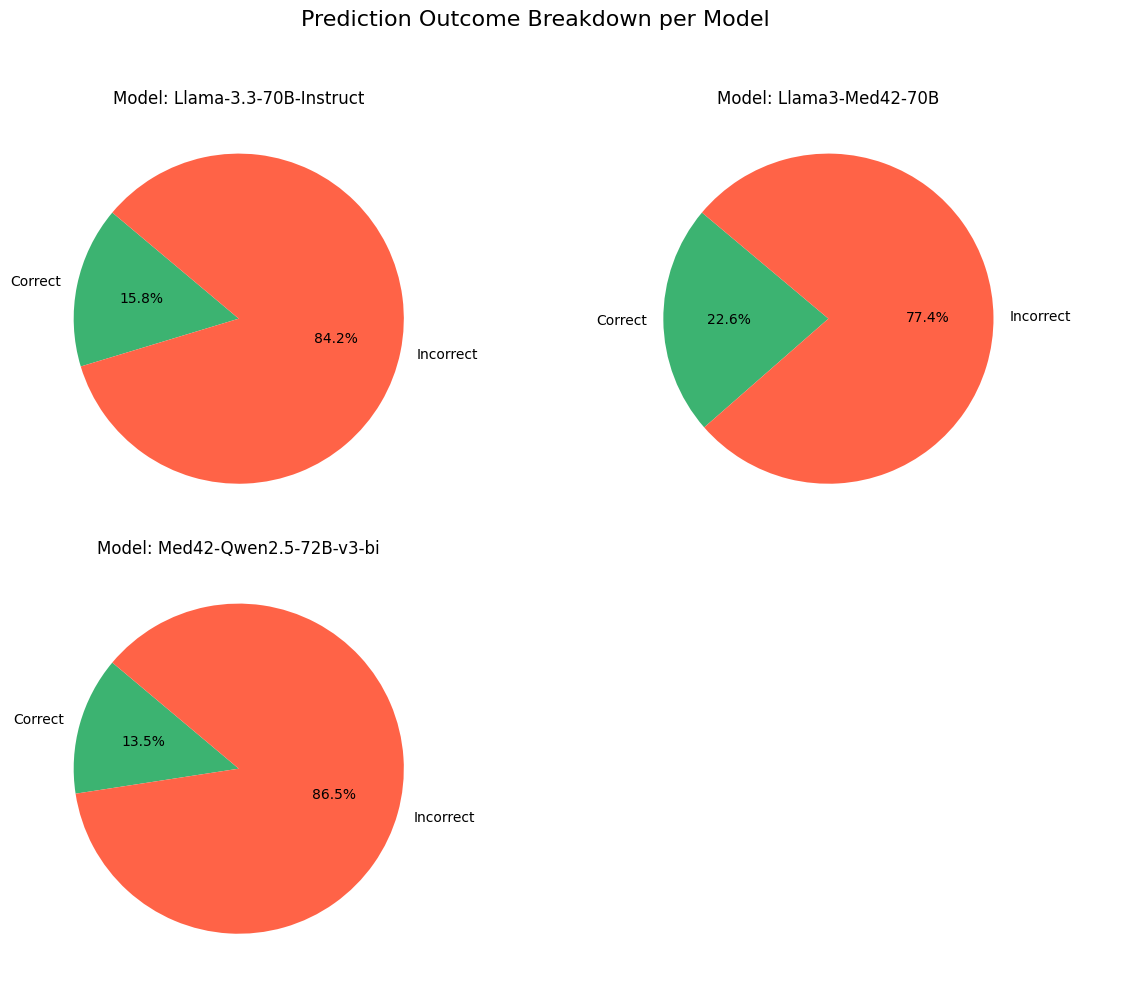

In [44]:
invalid_outputs, wrong_outputs, results_df,parsed_json = await run_models_with_output(
    sys_instruct=(
        "You are a helpful Medical Assistant. After you calculate the PERC score, provide an explanation of how "
        "you arrived at that score along with the score in JSON format. \n"
        "The JSON should be in the format: {\"Explanation\": \"<explanation>\", \"Answer\": <score>}"
    ),
    model_ids=model_ids,
    include_relevant_entities=True,
    full_df=True
)
plot_df_pie(results_df)


#### Simple prompt (does not include relevant entites in prompt)

In [56]:
invalid_outputs, wrong_outputs, results_df,parsed_json = await run_models_with_output(
    sys_instruct=(
        "You are a helpful Medical Assistant. After you calculate the PERC score, provide an explanation of how "
        "you arrived at that score along with the score in JSON format. \n"
        "The JSON should be in the format: {\"Explanation\": \"<explanation>\", \"Answer\": <score>}"
    ),
    model_ids=model_ids,
    include_relevant_entities=False,
    full_df=True
)
plot_df_pie(results_df)



=== Evaluating model: Llama-3.3-70B-Instruct ===

Batch Progress: 100.0% (133/133)
Parsing: 100.0% (133/133)
Done ✅

=== Evaluating model: Llama3-Med42-70B ===

Batch Progress: 45.1% (60/133)

CancelledError: 

#### Troubleshooting wrong/invalid replies

In [ ]:
#Troubleshooting: wrong/invalud outputs
for i, entry in enumerate(wrong_outputs):
    print(f"\n--- Wrong Reply {i+1} ---")
    print(f"Expected: {entry['expected']} | Predicted: {entry['predicted']}")
    print(f"Reply:\n{entry['reply']}")

# Extract invalid replies with metadata
for i, entry in enumerate(invalid_outputs):
    print(f"\n--- Invalid Reply {i+1} ---")
    print(f"Expected: {entry['expected']} | Predicted: {entry['predicted']}")
    print(f"Reply:\n{entry['reply']}")

invalid_replies = [entry['reply'] for entry in invalid_outputs if 'reply' in entry]
for i, reply in enumerate(invalid_replies):
    print(f"\n--- Invalid Reply {i+1} ---\n{reply}")


#### More detailed system instruction (includes relevant entities in prompt)


=== Evaluating model: Llama-3.3-70B-Instruct ===

Batch Progress: 100.0% (133/133)
Parsing: 100.0% (133/133)
Done ✅

=== Evaluating model: Llama3-Med42-70B ===

Batch Progress: 100.0% (133/133)
Parsing: 100.0% (133/133)
Done ✅

=== Evaluating model: Med42-Qwen2.5-72B-v3-bi ===

Batch Progress: 100.0% (133/133)
Parsing: 100.0% (133/133)
Done ✅

=== Evaluating model: Med42-R1-Qwen3-4B ===

Batch Progress: 100.0% (133/133)
Parsing: 100.0% (133/133)
Done ✅

=== Summary Table ===
                  model_id  wrong  correct  invalid  total  accuracy
0   Llama-3.3-70B-Instruct     93       38        2    133     0.290
1         Llama3-Med42-70B     93       30       10    133     0.244
2  Med42-Qwen2.5-72B-v3-bi     94       39        0    133     0.293
3        Med42-R1-Qwen3-4B     74       16       43    133     0.178


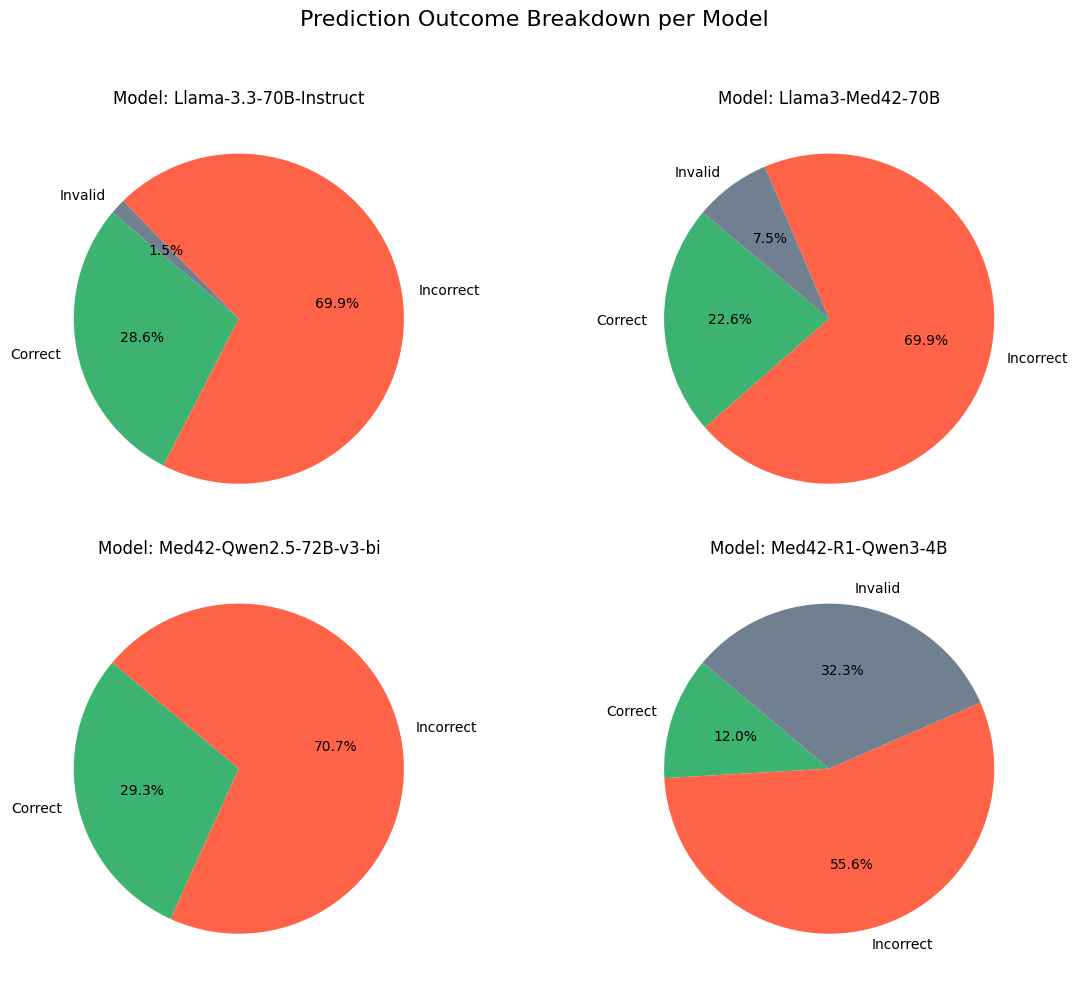

In [ ]:
sys_instruct = (
    "You are a clinical decision support assistant.\n"
    "\n"
    "Your task is to calculate the PERC (Pulmonary Embolism Rule-out Criteria) score for a patient using the note and extracted entities provided.\n"
    "\n"
    "There are 7 criteria. Each one is evaluated as either true (criterion met) or false (criterion not met). Each false criterion adds 1 point to the PERC score.\n"
    "\n"
    "PERC Criteria:\n"
    "1. Age < 50 years\n"
    "2. Heart rate < 100 bpm\n"
    "3. Oxygen saturation ≥ 95%\n"
    "4. No hemoptysis\n"
    "5. No estrogen use\n"
    "6. No prior venous thromboembolism (VTE)\n"
    "7. No unilateral leg swelling\n"
    "\n"
    "After your output return a **single JSON object*.\n"
    "\n"
    "Format:\n"
    "{\n"
    "  \"Explanation\": \"<A short explanation of how each criterion was evaluated>\",\n"
    "  \"Criteria\": {\n"
    "    \"Age < 50\": true or false,\n"
    "    \"HR < 100\": true or false,\n"
    "    \"O₂ ≥ 95%\": true or false,\n"
    "    \"No hemoptysis\": true or false,\n"
    "    \"No estrogen use\": true or false,\n"
    "    \"No prior VTE\": true or false,\n"
    "    \"No unilateral leg swelling\": true or false\n"
    "  },\n"
    "  \"Answer\": <sum of false values>\n"
    "}\n"
    "\n"

)
invalid_outputs, wrong_outputs, results_df,parsed_json = await run_models_with_output(
    sys_instruct = sys_instruct
    ,prompt="Calculate the PERC score for this patient based on the 7 criteria above. Explain how each criterion applies, then return the result in the specified JSON format.",
    model_ids=model_ids,
    include_relevant_entities=True,
    full_df=True
)
plot_df_pie(results_df)


#### More detailed system instruction (does not include relevant entities in prompt)


=== Evaluating model: Llama-3.3-70B-Instruct ===

Batch Progress: 100.0% (133/133)
Parsing: 100.0% (133/133)
Done ✅

=== Evaluating model: Llama3-Med42-70B ===

Batch Progress: 100.0% (133/133)
Parsing: 100.0% (133/133)
Done ✅

=== Evaluating model: Med42-Qwen2.5-72B-v3-bi ===

Batch Progress: 100.0% (133/133)
Parsing: 100.0% (133/133)
Done ✅

=== Summary Table ===
                  model_id  wrong  correct  invalid  total  accuracy
0   Llama-3.3-70B-Instruct     96       37        0    133     0.278
1         Llama3-Med42-70B    103       30        0    133     0.226
2  Med42-Qwen2.5-72B-v3-bi    111       22        0    133     0.165


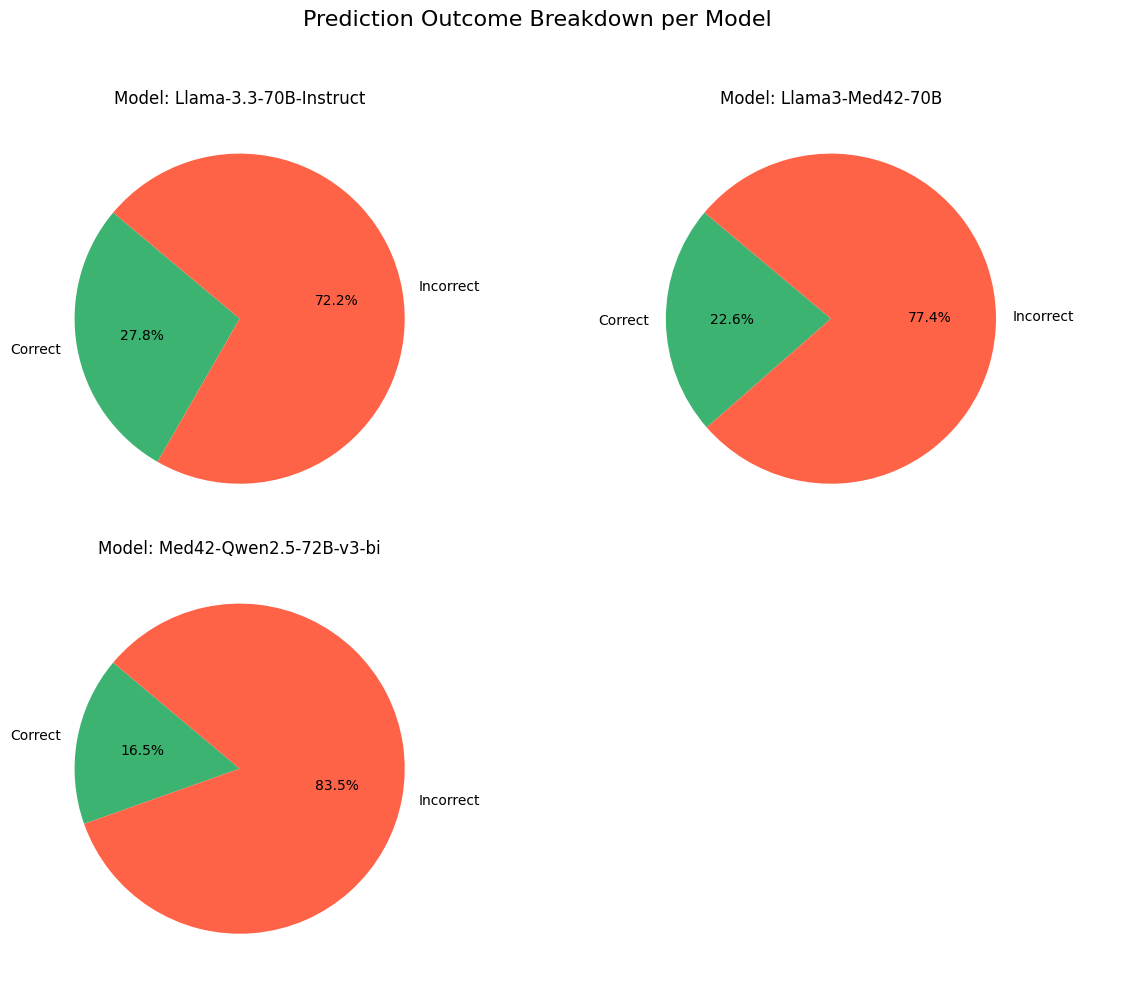

In [49]:
sys_instruct = (
    "You are a clinical decision support assistant.\n"
    "\n"
    "Your task is to calculate the PERC (Pulmonary Embolism Rule-out Criteria) score for a patient using the note and extracted entities provided.\n"
    "\n"
    "There are 7 criteria. Each one is evaluated as either true (criterion met) or false (criterion not met). Each false criterion adds 1 point to the PERC score.\n"
    "\n"
    "PERC Criteria:\n"
    "1. Age < 50 years\n"
    "2. Heart rate < 100 bpm\n"
    "3. Oxygen saturation ≥ 95%\n"
    "4. No hemoptysis\n"
    "5. No estrogen use\n"
    "6. No prior venous thromboembolism (VTE)\n"
    "7. No unilateral leg swelling\n"
    "\n"
    "After your output return a **single JSON object*.\n"
    "\n"
    "Format:\n"
    "{\n"
    "  \"Explanation\": \"<A short explanation of how each criterion was evaluated>\",\n"
    "  \"Criteria\": {\n"
    "    \"Age < 50\": true or false,\n"
    "    \"HR < 100\": true or false,\n"
    "    \"O₂ ≥ 95%\": true or false,\n"
    "    \"No hemoptysis\": true or false,\n"
    "    \"No estrogen use\": true or false,\n"
    "    \"No prior VTE\": true or false,\n"
    "    \"No unilateral leg swelling\": true or false\n"
    "  },\n"
    "  \"Answer\": <sum of false values>\n"
    "}\n"
    "\n"

)
invalid_outputs, wrong_outputs, results_df,parsed_json = await run_models_with_output(
    sys_instruct = sys_instruct
    ,prompt="Calculate the PERC score for this patient based on the 7 criteria above. Explain how each criterion applies, then return the result in the specified JSON format.",
    model_ids=model_ids,
    include_relevant_entities=False,
    full_df=True
)
plot_df_pie(results_df)


### Accuracy (Used the last detailed system instruction that did not include relevant entities in the prompt)

#### Outputs and Ground truth answer

In [ ]:
''' A function that computes the truth table for the PERC criteria based on parsed JSON outputs and patient data.
It returns a DataFrame with accuracy for each criterion per model.'''
def compute_truth_table(parsed_json, patient_df):
    rows = []

    def to_bool(val):
        if isinstance(val, bool):
            return val
        if isinstance(val, str):
            return val.lower() in ['true', 'yes', '1']
        return bool(val)

    for model_id, outputs in parsed_json.items():
        for i, output in enumerate(outputs):
            try:
                criteria_pred = output["parsed_criteria"]["Criteria"]
            except (TypeError, KeyError):
                continue  # skip bad or invalid outputs

            row = patient_df.iloc[i]
            entities = row["Parsed Entities"]

            age = extract_number(entities.get("age"))
            hr = extract_number(entities.get("Heart Rate or Pulse"))
            o2 = extract_number(entities.get("O₂ saturation percentage"))

            truth = {
                "Age < 50": age is not None and age < 50,
                "HR < 100": hr is not None and hr < 100,
                "O₂ ≥ 95%": o2 is not None and o2 >= 95,
                "No hemoptysis": not to_bool(entities.get("Hemoptysis", False)),
                "No estrogen use": not to_bool(entities.get("Estrogen use", False)),
                "No prior VTE": not to_bool(entities.get("Prior VTE", False)),
                "No unilateral leg swelling": not to_bool(entities.get("Unilateral leg swelling", False)),
            }

            for criterion, true_val in truth.items():
                pred_val = criteria_pred.get(criterion)
                match = (pred_val == true_val)
                rows.append({
                    "Model": model_id,
                    "Criterion": criterion,
                    "Correct": match
                })

    df = pd.DataFrame(rows)

    # Group by model and criterion, compute mean accuracy
    accuracy_df = (
        df.groupby(["Model", "Criterion"])["Correct"]
        .mean()
        .reset_index()
        .pivot(index="Criterion", columns="Model", values="Correct")
        .round(3)
    )

    return accuracy_df


In [101]:
accuracy_table = compute_truth_table(parsed_json, perc_df)
print(accuracy_table)


Model                       Llama-3.3-70B-Instruct  Llama3-Med42-70B  \
Criterion                                                              
Age < 50                                     0.549             0.561   
HR < 100                                     0.504             0.423   
No estrogen use                              0.962             0.813   
No hemoptysis                                0.887             0.854   
No prior VTE                                 0.962             0.756   
No unilateral leg swelling                   0.925             0.724   
O₂ ≥ 95%                                     0.549             0.528   

Model                       Med42-Qwen2.5-72B-v3-bi  
Criterion                                            
Age < 50                                      0.491  
HR < 100                                      0.462  
No estrogen use                               0.887  
No hemoptysis                                 0.868  
No prior VTE               

In [ ]:
'''A function that plots confusion matrices for each model and criterion based on parsed JSON outputs and patient data.
It creates a grid of subplots with each model's confusion matrix for each criterion.'''
def plot_confusion_matrices_by_model(parsed_json, patient_df):
    def to_bool(val):
        if isinstance(val, bool):
            return val
        if isinstance(val, str):
            return val.lower() in ['true', 'yes', '1']
        return bool(val)

    data = []

    for model_id, outputs in parsed_json.items():
        for i, output in enumerate(outputs):
            try:
                criteria_pred = output["parsed_criteria"]["Criteria"]
            except (TypeError, KeyError):
                continue

            row = patient_df.iloc[i]
            entities = row["Parsed Entities"]

            age = extract_number(entities.get("age"))
            hr = extract_number(entities.get("Heart Rate or Pulse"))
            o2 = extract_number(entities.get("O₂ saturation percentage"))

            truth = {
                "Age < 50": age is not None and age < 50,
                "HR < 100": hr is not None and hr < 100,
                "O₂ ≥ 95%": o2 is not None and o2 >= 95,
                "No hemoptysis": not to_bool(entities.get("Hemoptysis", False)),
                "No estrogen use": not to_bool(entities.get("Estrogen use", False)),
                "No prior VTE": not to_bool(entities.get("Prior VTE", False)),
                "No unilateral leg swelling": not to_bool(entities.get("Unilateral leg swelling", False)),
            }

            for criterion, true_val in truth.items():
                pred_val = criteria_pred.get(criterion)
                if pred_val is None:
                    continue
                data.append({
                    "Model": model_id,
                    "Criterion": criterion,
                    "True": true_val,
                    "Pred": pred_val,
                })

    df = pd.DataFrame(data)

    models = df["Model"].unique()
    criteria = df["Criterion"].unique()

    nrows = len(models)
    ncols = len(criteria)
    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows), squeeze=False)

    for i, model in enumerate(models):
        for j, criterion in enumerate(criteria):
            ax = axes[i][j]
            sub = df[(df["Model"] == model) & (df["Criterion"] == criterion)]
            cm = pd.crosstab(sub["True"], sub["Pred"])
            sns.heatmap(cm, annot=True, fmt="d", cbar=False, cmap="Blues", ax=ax)
            ax.set_title(f"{model} — {criterion}")
            ax.set_xlabel("Predicted")
            ax.set_ylabel("Actual")

    plt.tight_layout()
    plt.show()


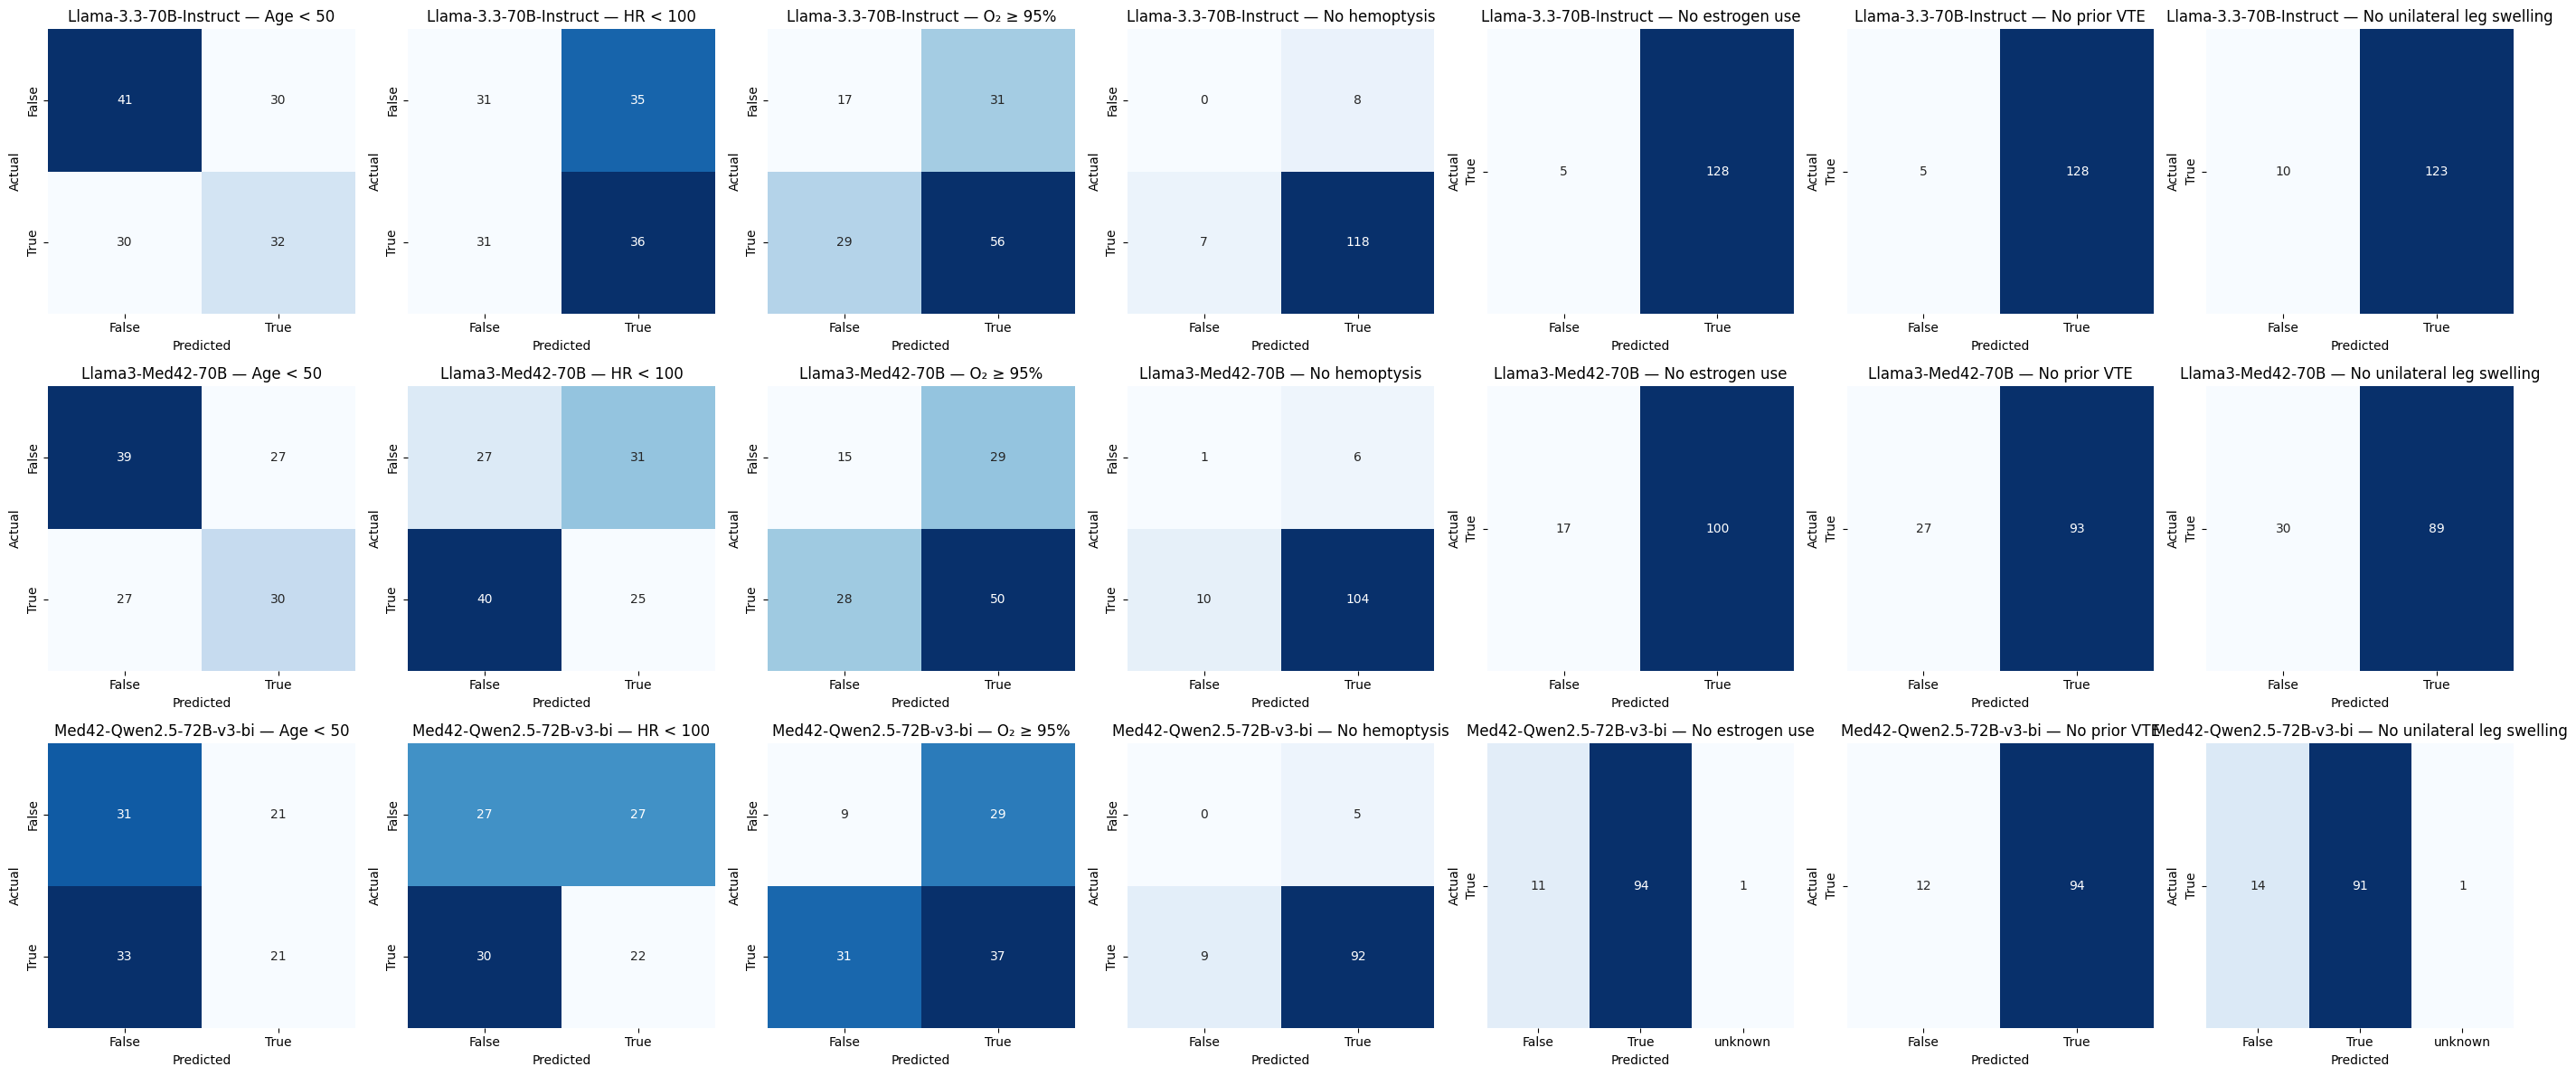

In [110]:
plot_confusion_matrices_by_model(parsed_json, perc_df)

In [ ]:
''' A function that plots the accuracy of PERC criteria by outcome (correct or incorrect) for each model.
It creates a heatmap for each outcome type, showing the accuracy of each criterion per model.'''
def plot_criteria_accuracy_by_outcome(parsed_json, patient_df):
    def to_bool(val):
        if isinstance(val, bool):
            return val
        if isinstance(val, str):
            return val.lower() in ['true', 'yes', '1']
        return bool(val)

    def compute_data(filter_correct: bool):
        rows = []
        for model_id, outputs in parsed_json.items():
            for i, output in enumerate(outputs):
                if output.get("correct") != filter_correct:
                    continue

                try:
                    criteria_pred = output["parsed_criteria"]["Criteria"]
                except (TypeError, KeyError):
                    continue

                row = patient_df.iloc[i]
                entities = row["Parsed Entities"]

                age = extract_number(entities.get("age"))
                hr = extract_number(entities.get("Heart Rate or Pulse"))
                o2 = extract_number(entities.get("O₂ saturation percentage"))

                truth = {
                    "Age < 50": age is not None and age < 50,
                    "HR < 100": hr is not None and hr < 100,
                    "O₂ ≥ 95%": o2 is not None and o2 >= 95,
                    "No hemoptysis": not to_bool(entities.get("Hemoptysis", False)),
                    "No estrogen use": not to_bool(entities.get("Estrogen use", False)),
                    "No prior VTE": not to_bool(entities.get("Prior VTE", False)),
                    "No unilateral leg swelling": not to_bool(entities.get("Unilateral leg swelling", False)),
                }

                for criterion, true_val in truth.items():
                    pred_val = criteria_pred.get(criterion)
                    if pred_val is None:
                        continue
                    match = (pred_val == true_val)
                    rows.append({
                        "Model": model_id,
                        "Criterion": criterion,
                        "CorrectCriterion": match
                    })

        return pd.DataFrame(rows)

    # Get data for both correct and incorrect predictions
    correct_df = compute_data(filter_correct=True)
    incorrect_df = compute_data(filter_correct=False)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

    for df, ax, title in zip(
        [correct_df, incorrect_df],
        axes,
        ["Given Correct Final Answer", "Given Incorrect Final Answer"]
    ):
        if df.empty:
            ax.set_visible(False)
            continue

        summary = (
            df.groupby(["Model", "Criterion"])["CorrectCriterion"]
            .mean()
            .reset_index()
            .pivot(index="Criterion", columns="Model", values="CorrectCriterion")
            .round(3)
        )

        sns.heatmap(summary, annot=True, fmt=".2f", cmap="Blues", vmin=0, vmax=1, cbar=True, ax=ax)
        ax.set_title(f"Criterion Accuracy — {title}")
        ax.set_xlabel("Model")
        ax.set_ylabel("PERC Criterion")

    plt.tight_layout()
    plt.show()


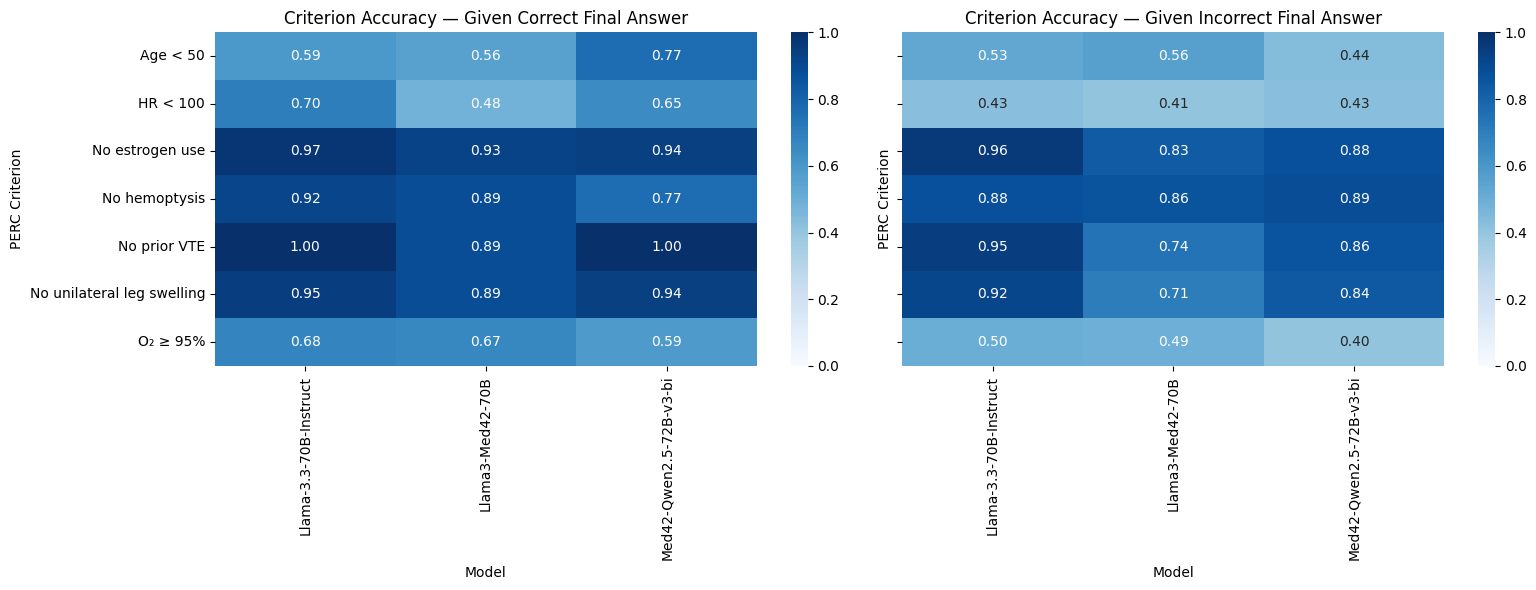

In [149]:
plot_criteria_accuracy_by_outcome(parsed_json, perc_df)


#### Criteria and Answer Accuracy

In [ ]:
''' A quick function to plot a pie chart showing the breakdown of correct vs incorrect criteria for each model.'''
def plot_criteria_accuracy_pie(parsed_json, patient_df):
    def to_bool(val):
        if isinstance(val, bool):
            return val
        if isinstance(val, str):
            return val.lower() in ['true', 'yes', '1']
        return bool(val)

    all_correct = 0
    some_wrong = 0

    for model_id, outputs in parsed_json.items():
        for i, output in enumerate(outputs):
            if output.get("correct"):
                continue  # Only look at incorrect answers

            try:
                criteria_pred = output["parsed_criteria"]["Criteria"]
            except (TypeError, KeyError):
                continue

            row = patient_df.iloc[i]
            entities = row["Parsed Entities"]

            age = extract_number(entities.get("age"))
            hr = extract_number(entities.get("Heart Rate or Pulse"))
            o2 = extract_number(entities.get("O₂ saturation percentage"))

            truth = {
                "Age < 50": age is not None and age < 50,
                "HR < 100": hr is not None and hr < 100,
                "O₂ ≥ 95%": o2 is not None and o2 >= 95,
                "No hemoptysis": not to_bool(entities.get("Hemoptysis", False)),
                "No estrogen use": not to_bool(entities.get("Estrogen use", False)),
                "No prior VTE": not to_bool(entities.get("Prior VTE", False)),
                "No unilateral leg swelling": not to_bool(entities.get("Unilateral leg swelling", False)),
            }

            match_flags = []
            for criterion, true_val in truth.items():
                pred_val = criteria_pred.get(criterion)
                if pred_val is None:
                    continue
                match_flags.append(pred_val == true_val)

            if builtins.all(match_flags) and match_flags:
                all_correct += 1
            else:
                some_wrong += 1

    total = all_correct + some_wrong
    if total == 0:
        print("No incorrect predictions found to analyze.")
        return

    labels = ["All Criteria Correct", "One or More Incorrect"]
    sizes = [all_correct, some_wrong]
    colors = ["mediumseagreen", "tomato"]

    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct="%1.1f%%", colors=colors, startangle=140)
    plt.title("Criteria Accuracy Breakdown for Incorrect Predictions")
    plt.tight_layout()
    plt.show()


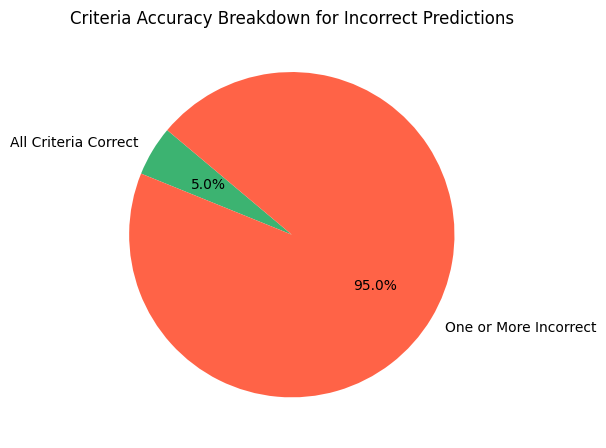

In [147]:
plot_criteria_accuracy_pie(parsed_json, perc_df)
